## OFDM Signal Processing

A complete **baseband receiver-side analysis** of an OFDM signal:

* Synchronization via energy threshold and correlation
* CP detection to validate symbol structure
* FFT demodulation for symbol extraction
* Visualization of constellation and power spectrum
* Subcarrier diagnostics for quality inspection

Unkown parameters: 

- CP length
- FFT length
- Symbol start index
 - Null subcarriers


This framework is valuable for evaluating **modulation integrity**, **timing accuracy**, and **subcarrier behavior** in both simulated and real-world OFDM systems.


### 1. **Signal Preprocessing**

* Load the received signal (input data)
* Define OFDM parameters:

  * Estimated symbol length
  * Estimated cyclic prefix
  * Total symbol length

### 2. **Autocorrelation for Rough Symbol Start**

* Compute autocorrelation of the received signal to identify repeating structure.
* Detect the **initial start index** of OFDM symbols based on energy thresholding.
* Use a moving window to refine this estimate.


### 3. **Cyclic Prefix (CP) Correlation-Based Detection**

* Sweep over candidate start indices around the rough estimate.
* For each, check the correlation between CP and end of symbols.
* Select the start index that gives the **maximum average CP correlation**.


### 4. **Downsampling and Multiple Tests**

* Optionally test different values of symbol scaling or downsampling factor

* Analyze resolution and robustness across symbol lengths.


### 5. **Symbol Extraction and FFT**

* From the chosen start index, extract all OFDM symbols.
* Remove the cyclic prefix from each.
* Perform FFT on each symbol to transform to the frequency domain.
* Apply `fftshift` to center the DC subcarrier.


### 6. **Constellation Plotting**

* Flatten all subcarriers from all symbols into a single array.
* Plot real vs. imaginary values of subcarriers to visualize:

  * Identify modulation type (e.g., QPSK, QAM)
  * Analyze signal quality and distortions

### 7. **Subcarrier Power Analysis**

* Calculate power per subcarrier for each symbol.
* Identify **low-power (null or attenuated)** subcarriers.
* Use `stem` plots to highlight which subcarriers fall below a threshold (e.g., power < threshold).
* Overplot known null subcarriers for verification.


### 8. **Focused Subcarrier Constellation**

* Extract only the **useful subcarriers**
* Discard DC or null subcarriers
* Flatten and visualize constellation from these active carriers.

---

# 1. Signal Preprocessing 

dict_keys(['__header__', '__version__', '__globals__', 'final_signal'])


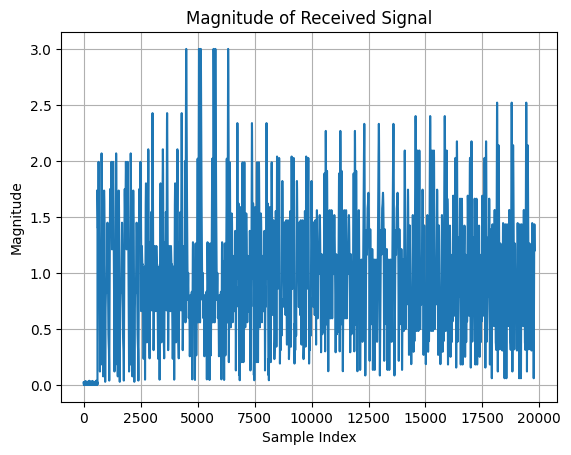

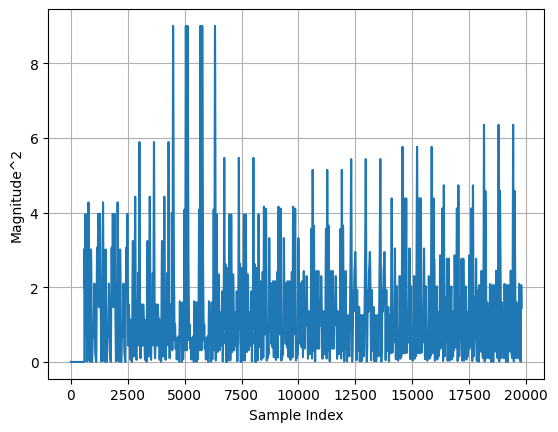

In [192]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os

# Load the received signal

Received = scipy.io.loadmat('ofdm_rx_signal.mat')
print(Received.keys())
rx_signal = Received['final_signal']  
rx_signal = rx_signal.squeeze()  # Convert (n,1) to (n,) if needed

plt.figure()
plt.plot(np.abs(rx_signal))  # Magnitude
plt.title('Magnitude of Received Signal')
plt.xlabel('Sample Index')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(np.abs(rx_signal)**2)  # Magnitude
plt.xlabel('Sample Index')
plt.ylabel('Magnitude^2')
plt.grid(True)
plt.show()


## 2. Autocorrelation Analysis of Received Signal

Computing **autocorrelation** of the received signal to analyze its periodic structure and estimate symbol length.

### Autocorrelation Function

For a real-valued discrete signal $x[n]$, the autocorrelation function $R_{xx}[k]$ is defined as:

$$
R_{xx}[k] = \sum_{n} x[n] \cdot x[n+k]
$$

Where:

* $k$ is the **lag** (shift),
* For negative $k$, we evaluate $x[n] \cdot x[n - |k|]$,
* For normalization (`'coeff'`), we divide by the maximum value of $|R_{xx}[k]|$.

### Why Autocorrelation?

* Peaks in the autocorrelation function at non-zero lags can indicate **periodic patterns**.
* In digital communications, repeated symbol structures create peaks at multiples of **symbol length**.
* Here, a peak at lag = x, suggests the symbol duration is approximately **x samples**.


* Repeated peaks suggest periodicity in the received signal.
* If a peak occurs at lag ≈ x, it implies a **symbol duration** of x samples:


## Start Index Detection Based on Noise Threshold

The **start of the useful signal** in a received waveform based on power thresholding

- Estimate background noise power from the samples.
- Detect where the signal power significantly exceeds the noise.
- Mark and highlight a region around the detected start index.


### Noise Power Estimation

If roughly N samples are noisy samples at the beginning of received signal, then:

$$
P_{\text{noise}} = \frac{1}{N} \sum_{n=1}^{N} |x[n]|^2
$$

Where:

- \( x[n] \) is the received signal,
- \( |x[n]| \) is the magnitude (for complex signals).

### Threshold-Based Detection

We detect the **first index** where the signal power exceeds a multiple of the noise power:

$$
\text{start\_index} = \min \left\{ n : |x[n]|^2 > \text{Threshold} \cdot P_{\text{noise}} \right\}
$$



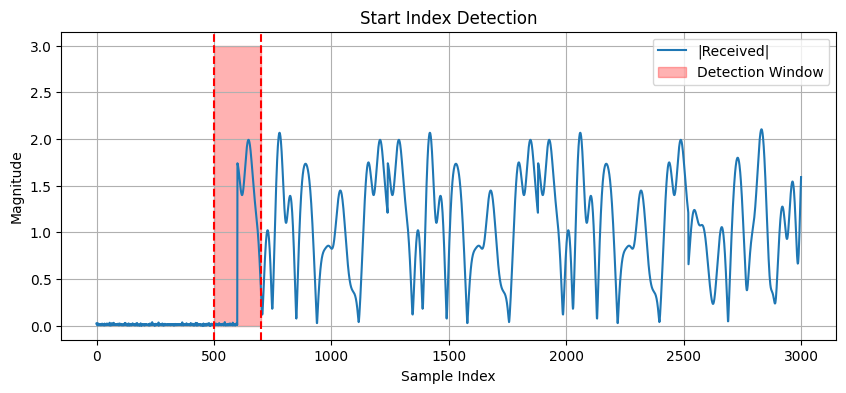

Start Index of Signal: 600


In [220]:
noise1_power = np.mean(np.abs(rx_signal[:700])**2) 
# 4000 is an arbitrary choice for noise estimation according the figure of received signal 
Threshold = 0.5 # the threshold factor is empirically chosen

# Find the start index where signal power exceeds noise threshold
ind = np.where(np.abs(rx_signal)**2 > Threshold * noise1_power)[0]
start_index = ind[0] if len(ind) > 0 else None

# Plot up to 5×start_index
plt.figure(figsize=(10, 4))
plt.plot(np.abs(rx_signal[:5*start_index]), label='|Received|')
plt.axvline(start_index - 100, color='r', linestyle='--')
plt.axvline(start_index + 100, color='r', linestyle='--')

# Shade the region from (start_index - 100) to (start_index + 100)
x_shade = [start_index - 100, start_index + 100, start_index + 100, start_index - 100]
y_shade = [0, 0, 3, 3]  # Adjust height if needed based on your signal

plt.fill(x_shade, y_shade, color='red', alpha=0.3, label='Detection Window')
plt.title("Start Index Detection")
plt.xlabel("Sample Index")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()
plt.show()
print("Start Index of Signal:", start_index)

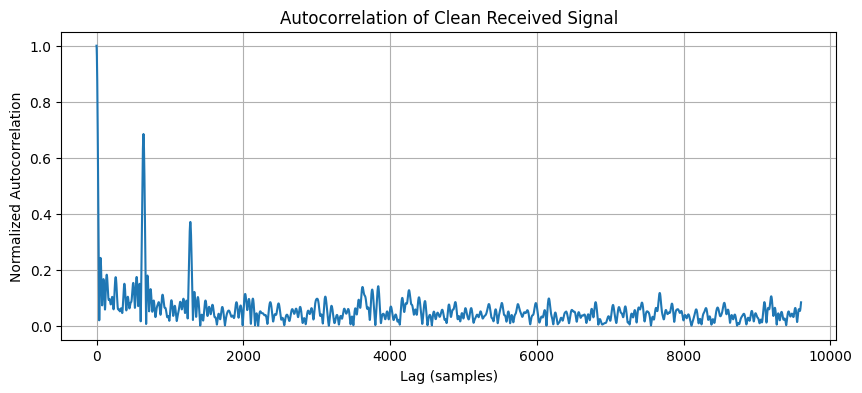

Detected peak lags: [ 640 1279]
Estimated Symbol Duration: 640 samples


In [221]:
from scipy.signal import find_peaks
rx_clean = rx_signal[start_index+1:]  # Remove noise before OFDM signal
N = len(rx_clean)
max_lag = N // 2

# Autocorrelation
Rxx_full = np.correlate(rx_clean, rx_clean, mode='full')
lags = np.arange(-N + 1, N)
Rxx_full = Rxx_full / np.max(np.abs(Rxx_full))  # Normalize

# Take positive lags
mid_index = len(Rxx_full) // 2
Rxx_positive = Rxx_full[mid_index:(mid_index + max_lag + 1)]
lags_positive = lags[mid_index:(mid_index + max_lag + 1)]

# Plot
plt.figure(figsize=(10, 4))
plt.plot(lags_positive, np.abs(Rxx_positive))
plt.title('Autocorrelation of Clean Received Signal')
plt.xlabel('Lag (samples)')
plt.ylabel('Normalized Autocorrelation')
plt.grid(True)
plt.show()

# Find peaks
peaks, _ = find_peaks(np.abs(Rxx_positive), height=0.3, distance=300)
peak_lags = lags_positive[peaks]
print("Detected peak lags:", peak_lags)

# Estimate symbol duration
if len(peak_lags) >= 2:
    diffs = np.diff(peak_lags)
    symbol_duration_est = int(np.median(diffs)) + 1
    print("Estimated Symbol Duration:", symbol_duration_est, "samples")
else:
    print("Not enough peaks found to estimate symbol duration.")


# 3. Cyclic Prefix (CP) Correlation-Based Detection

Implementing a correlation-based search to **refine the start index** of an OFDM-like signal by detecting the **CP** structure within a predefined range.

To scan a window of possible start indices near the initial estimate and find the one that:

- Maximizes **CP autocorrelation**, indicating correct symbol alignment.
- Helps identify where **OFDM symbols** begin reliably.

### OFDM Symbol Structure

- Each symbol has a **CP** prepended.
- CP is a copy of the last part of the symbol.
- This helps mitigate inter-symbol interference (ISI) and aids synchronization.

If  \(L_d\)  is the symbol length and \(L_{cp}\) is the CP length, the total symbol duration is:

$$
T_d = L_{cp} + L_d
$$



### CP Correlation Metric

To detect the symbol start, we compute the **correlation** between:

The **first \( L_{cp} \)** samples of the symbol, and  
The **last \( L_{cp} \)** samples of the same symbol.

$$
\text{Correlation}(L_{cp}) = \left| \sum_{n=0}^{L_{cp}-1} x[n] \cdot x^*[T_d - L_{cp} + n] \right|
$$

This is computed for several symbols and averaged across symbols to smooth the estimate.


### Assumptions

- Each OFDM-like symbol has length `Ld`
- The total symbol duration is `Td = L_cp + Ld`, where `L_cp` is the cyclic prefix.
- The signal starts approximately at sample 398.


For a candidate CP length `L_cp`, and a symbol starting at index \( i \), the **cyclic prefix correlation** is:

$$
Correlation(L_{cp}, i) = | sum( conj(x[0:L_{cp}]) * x[-L_{cp}:] ) |
$$

Where:

- `x` is the signal segment of one symbol of length `Td = L_cp + Ld`,

- `x[0:L_cp]` is the start (prefix),

- `x[-L_cp:]` is the end (suffix),

- The correlation magnitude evaluates cyclic similarity.



### Algorithm Steps

1. **Scan candidate start indices** from `start_index - 200` to `start_index + 200`.

2. For each candidate `j`, extract the signal: `x = rx_signal[j:]`.

3. For each possible CP length 
            $$L_{cp} \in [1, L_d/4]$$

    - Loop over 17 symbols (`i = 3` to `18`).
    - For each symbol, extract the CP and tail, then compute their correlation.


4. Store the **maximum average correlation** across CP lengths for each candidate index.

5. Identify the index with **maximum CP alignment**.


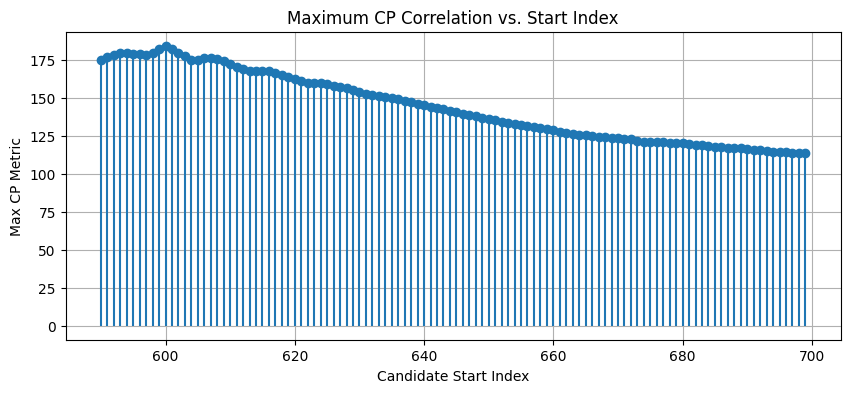

Maximum CP Metric = 184.47 at index = 600


In [222]:
Signal = rx_signal
Ld = symbol_duration_est - 80
mm = [] # maximum metric for CP
search_range = range(start_index - 10, start_index + 100)

# Loop over potential start indices around estimated start_index
for j in search_range:
    x = Signal[j:]
    c = np.zeros((Ld // 4, 14))  # Rows: possible CP lengths, Cols: symbols (3 to 18)

    for i in range(1, 14):  # symbol indices
        for cp_len in range(1, Ld // 4 + 1):
            Td = cp_len + Ld
            start = (i - 1) * Td
            end_ = i * Td
            if end_ > len(x):
                continue
            x1 = x[start:end_]
            c[cp_len - 1, i] = np.abs(np.sum(np.conj(x1[:cp_len]) * x1[-cp_len:]))

    cp_avg = np.mean(c, axis=1)
    mm.append(np.max(cp_avg))

j_range = list(search_range)
mm = np.array(mm)

plt.figure(figsize=(10, 4))
plt.stem(j_range, mm, linefmt='C0-', markerfmt='C0o', basefmt=" ")
plt.title("Maximum CP Correlation vs. Start Index")
plt.xlabel("Candidate Start Index")
plt.ylabel("Max CP Metric")
plt.grid(True)
plt.show()

# Best start
mm_max_idx = j_range[np.argmax(mm)]
print(f"Maximum CP Metric = {np.max(mm):.2f} at index = {mm_max_idx}")


### Cyclic Prefix Estimation for Fixed Start Index

Examining the structure of an OFDM-like signal starting from a fixed `start_index` to evaluate the correlation between the cyclic prefix and the end of each symbol.

- Detect if the signal exhibits repeated cyclic structure.
- Plot correlation metrics per symbol.
- Average correlation results to validate CP length estimation.

### Algorithm

1. For each symbol index `i = 3` to `20`:

   - Try all possible CP lengths from 1 to `Ld / 4`.

   - Extract the full symbol of length `Td = L_cp + Ld`.

   - Compute correlation between prefix and suffix.

   - Store result in a matrix `c`.

2. Plot correlation profile for each symbol:

   - X-axis: CP length candidate
   - Y-axis: Correlation magnitude

3. Average the CP correlation results over all symbols:

   - This helps remove noise and verify stable structure.

4. Report maximum averaged correlation:

   - Indicates strongest CP candidate for alignment.



This analysis helps visually verify whether a **cyclic prefix structure** exists and if the starting point is aligned with the symbol boundary.

- Sharp peaks in correlation plots confirm cyclic structure.
- High average correlation across multiple symbols suggests reliable CP detection.


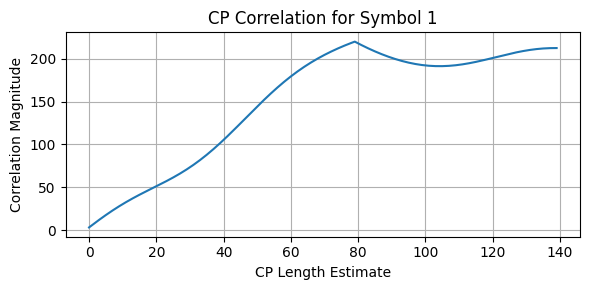

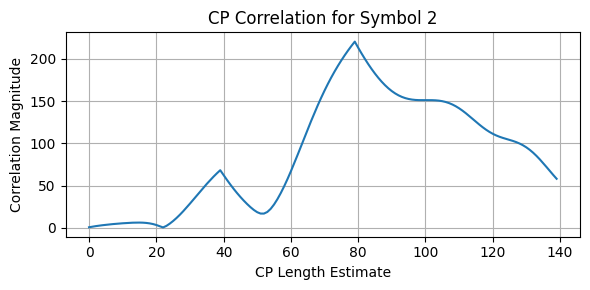

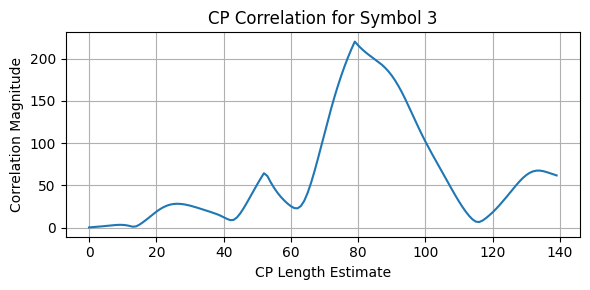

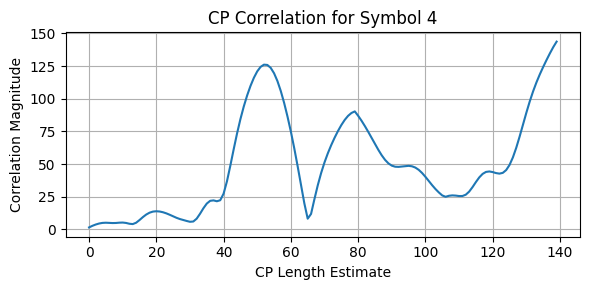

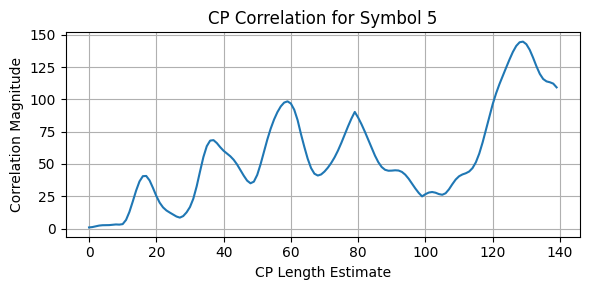

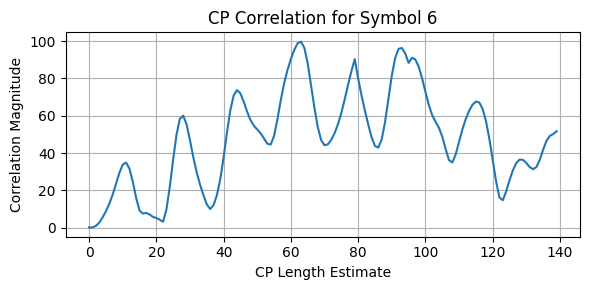

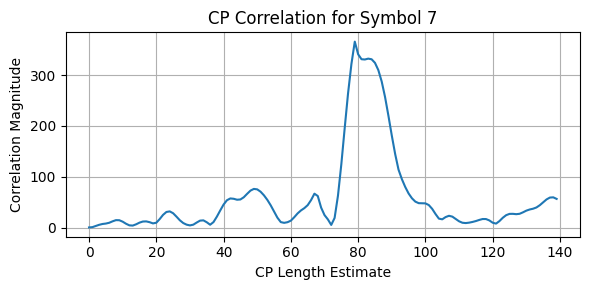

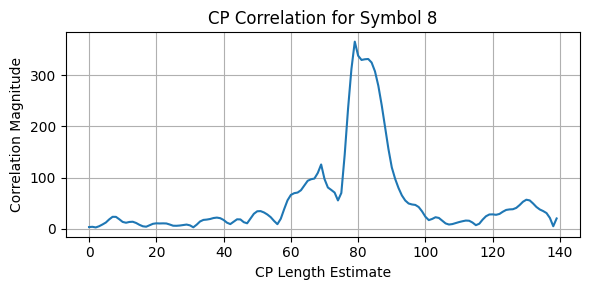

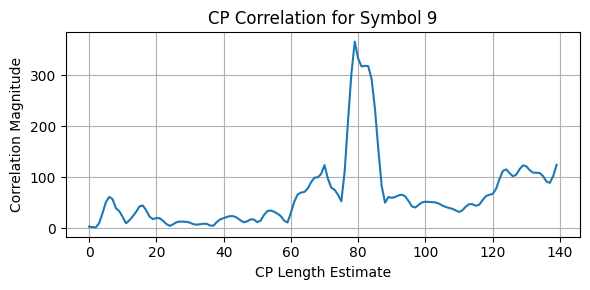

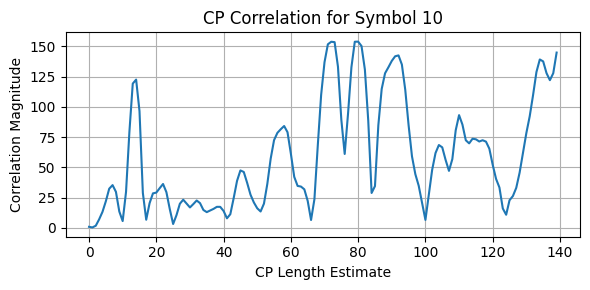

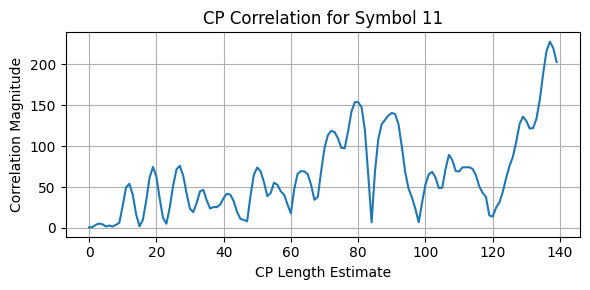

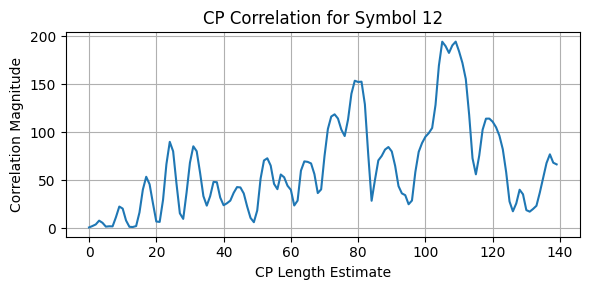

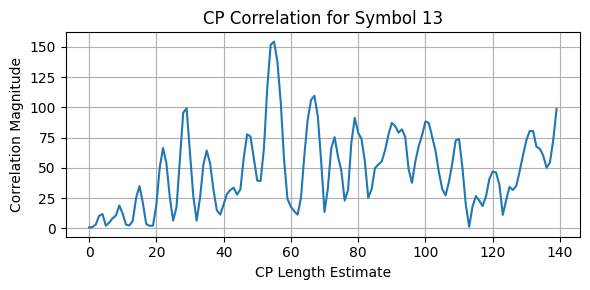

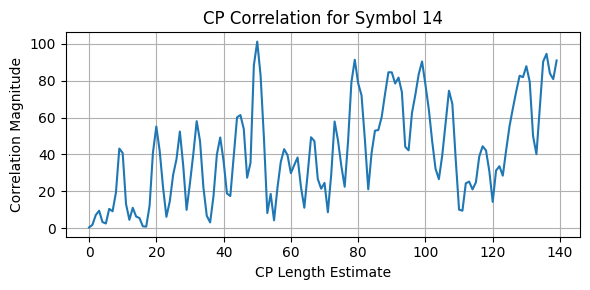

Max averaged CP correlation: 178.2621


In [223]:
x = Signal[start_index:]
c = np.zeros((Ld // 4, 15))  # Rows: CP lengths, Cols: symbol instances 

# Process each symbol index from 3 to 20
for i in range(1, 15):
    for cp_length_est in range(1, Ld // 4 + 1):
        Td = cp_length_est + Ld  # Total duration of one symbol with CP
        start = (i - 1) * Td
        end_ = i * Td
        if end_ > len(x):  # Safety check
            continue
        x1 = x[start:end_]
        c[cp_length_est - 1, i-1] = np.abs(np.sum(np.conj(x1[:cp_length_est]) * x1[-cp_length_est:]))

    # Plot each symbol's CP correlation profile
    plt.figure(figsize=(6, 3))
    plt.plot(c[:, i - 1])
    plt.title(f"CP Correlation for Symbol {i}")
    plt.xlabel("CP Length Estimate")
    plt.ylabel("Correlation Magnitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Average CP correlation across symbols
cp_avg = np.mean(c, axis=1)

# Store maximum correlation (for this fixed start_index)
mm_val = np.max(cp_avg)
print(f"Max averaged CP correlation: {mm_val:.4f}")


### OFDM Symbol Extraction and Constellation Plotting

This process analyzes an OFDM-like signal by segmenting it into symbols, removing cyclic prefixes (CP), performing FFT, and plotting the **constellation diagram** to visualize modulation characteristics.

- Support symbol extraction at different downsampling factors `k`.
- Apply CP removal and FFT per symbol.
- Flatten the frequency-domain symbols into one array.
- Plot the resulting constellation.


### Downsampling and Parameters

For each `k` in `[1, 2, 4, ..., 40]`:

    - Estimated cyclic prefix: `Lcp = 80 / k`
    - Data (useful) length: `Ld = 640 / k`
    - Total symbol duration: `Ls = Lcp + Ld`

We apply optional downsampling by factor `k`:
```python
x = x_raw[::k]


# Mathematical Steps

1. **Symbol Slicing**

   From the signal $x[n]$, we extract an integer number of symbols:

   $$
   \text{total\_length} = \text{num\_symbols} \times L_s
   $$

   Then reshape into matrix $x_{\text{symbols}} \in \mathbb{C}^{L_s \times N_{\text{sym}}}$.

2. **CP Removal**

   Remove first `Lcp` samples of each symbol:

   $$
   x_{\text{no\_cp}} = x_{\text{symbols}}[L_{\text{cp}}:, :]
   $$

3. **FFT per Symbol**

   Apply FFT to each column (symbol):

   $$
   X_k = \text{FFT}(x_{\text{no\_cp}}[:, k])
   $$

4. **FFT Shift**

   Center the DC component using `fftshift`.

5. **Flatten Constellation**

   Flatten all subcarriers from all symbols:

   $$
   \text{constellation\_points} = \text{flatten}(X_{\text{symbols}})
   $$

Processing for k = 1
  Lcp = 80, Ld = 640, Ls = 720
  Start index = 600


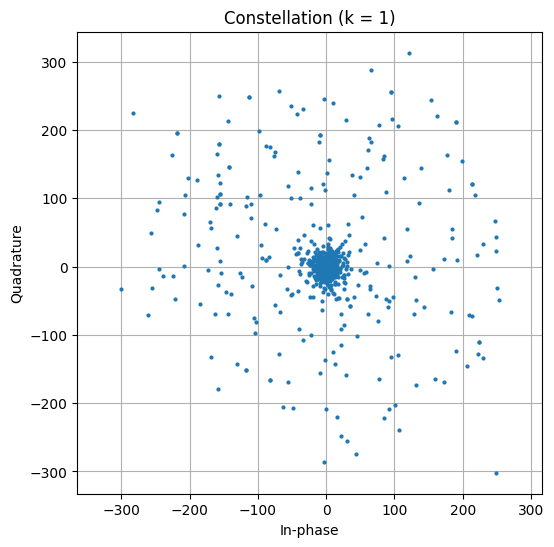

In [241]:
x_raw = rx_signal

# Optional: visualize multiple downsampling factors
for k in [1]:  # You can extend to [1, 2, 4, 5, 8, 10, 16, 20, 40]
    print(f"Processing for k = {k}")
    
    # Lcp = int(np.max(mm) / k)
    Lcp = int(80/k)
    # Ld = int(mm_max_idx / k)
    Ld = int(640/k)
    Ls = Lcp + Ld  # Total symbol length
    print(f"  Lcp = {Lcp}, Ld = {Ld}, Ls = {Ls}")

    # Optional: downsampling
    x = x_raw[::k]

    for indd in [start_index]:
        print(f"  Start index = {indd}")
        x = x_raw[indd:]
        N = len(x)
        num_symbols = 14  # Fixed manually
        total_length = num_symbols * Ls

        if total_length > N:
            print("  Not enough data to extract symbols.")
            continue

        x_truncated = x[:total_length]

        # Reshape into symbols: shape = (Ls, num_symbols)
        x_symbols = x_truncated.reshape((Ls, num_symbols), order='F')

        # Remove CP from each symbol (result: shape = (Ld, num_symbols))
        x_no_cp = x_symbols[Lcp:, :]

        # Perform FFT on each column (along rows)
        X_symbols = np.fft.fft(x_no_cp, n=Ld, axis=0)

        # Shift frequency spectrum (zero-freq to center)
        X_symbols = np.fft.fftshift(X_symbols, axes=0)

        # Flatten to 1D vector
        constellation_points = X_symbols.flatten()

        # Plot the constellation
        plt.figure(figsize=(6, 6))
        plt.plot(np.real(constellation_points), np.imag(constellation_points), 'o', markersize=2)
        plt.title(f'Constellation (k = {k})')
        plt.xlabel('In-phase')
        plt.ylabel('Quadrature')
        plt.grid(True)
        plt.axis('equal')
        plt.show()



## Signal Segmentation and FFT

### OFDM Demodulation and Constellation Plotting

Implementation of an OFDM demodulation process that uses multiple start indices to extract frequency-domain constellation points.

- Refine symbol synchronization using multiple candidate start indices.
- Demodulate OFDM-like symbols by removing the cyclic prefix and performing FFT.
- Visualize constellation points for quality analysis of the modulation scheme.

### Parameters

   - **Downsampling factor (k):** Determines resolution. Only `k = 1` is used in this run.
   - **Cyclic Prefix (CP) length:** `Lcp = 80 / k`
   - **Data symbol length (Ld):** `Ld = 640 / k`
   - **Total symbol length:** `Ls = Lcp + Ld`
   - **Start indices tested:** `indd ∈ [397, 398, 399]`
   - **Number of symbols:** Fixed at 21



1. **Start Index Selection**

   - For each `indd` in the range `[397, 398, 399]`, the signal is processed from that point onward.
   - This tests alignment sensitivity.

2. **Signal Truncation**

   - Extract a fixed number of complete OFDM symbols (21 symbols of length `Ls`).
   - The signal is reshaped into a 2D matrix of size `(Ls, num_symbols)`.

3. **Cyclic Prefix Removal**

   - For each symbol, remove the first `Lcp` samples.
   - Resulting matrix has shape `(Ld, num_symbols)`.

4. **FFT Processing**

   - Apply FFT to each symbol column to transform into the frequency domain.
   - Use `fftshift` to center the DC component.

5. **Flatten and Plot**

   - Flatten the matrix into a 1D array of constellation points.
   - Plot the real vs. imaginary parts to visualize modulation (e.g., QPSK, 16-QAM).




Processing with k=1, Lcp=80, Ld=640, Ls=720
  Processing start index: 600


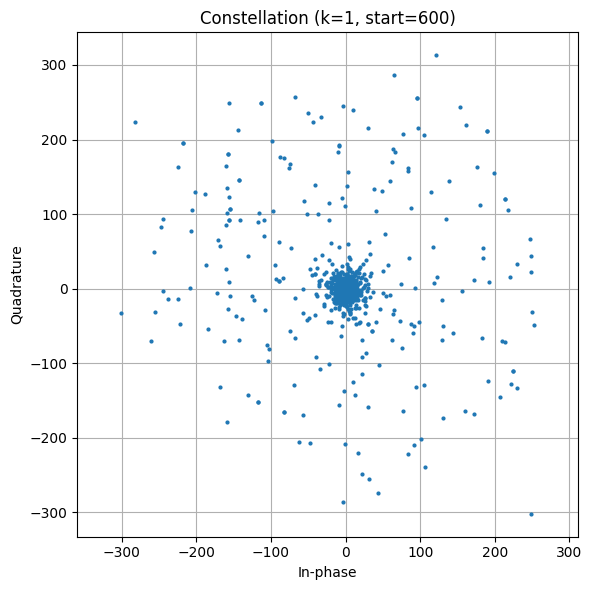

  Processing start index: 601


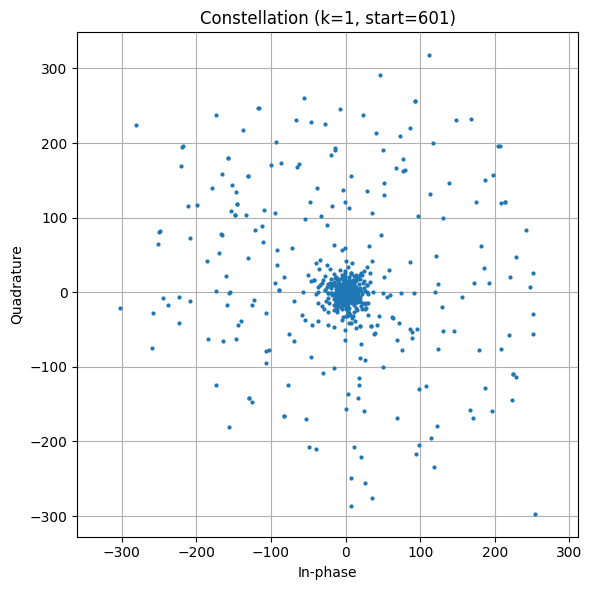

  Processing start index: 602


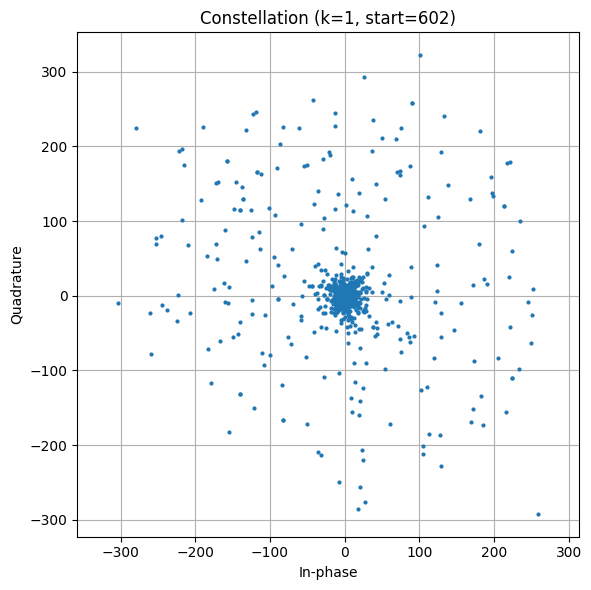

In [243]:
# Optional: try other k values like [1, 2, 4, 5, 8, 10, 16, 20, 40]
for k in [1]:
    Lcp = int(80 / k)  # Adjusted CP length
    Ld = int(640 / k)  # Adjusted data (useful symbol) length
    Ls = Lcp + Ld      # Total OFDM symbol length

    print(f"\nProcessing with k={k}, Lcp={Lcp}, Ld={Ld}, Ls={Ls}")

    # Downsampled version (optional)
    x_down = x_raw[::k]

    for indd in range(start_index, start_index + 3):  
        print(f"  Processing start index: {indd}")
        x = x_raw[indd:]
        N = len(x)

        num_symbols = 14
        total_length = num_symbols * Ls

        if total_length > N:
            print("  Skipping: Not enough data.")
            continue

        # Truncate signal to complete symbols
        x_truncated = x[:total_length]

        # Reshape into (Ls, num_symbols) matrix
        x_symbols = x_truncated.reshape((Ls, num_symbols), order='F')

        # Remove CP from each symbol → shape (Ld, num_symbols)
        x_no_cp = x_symbols[Lcp:, :]

        # Apply FFT on each symbol (column-wise)
        X_symbols = np.fft.fft(x_no_cp, n=Ld, axis=0)

        # Shift zero-frequency to center
        X_symbols = np.fft.fftshift(X_symbols, axes=0)

        # Flatten to form 1D list of constellation points
        constellation_points = X_symbols.flatten()

        # Plot
        plt.figure(figsize=(6, 6))
        plt.plot(np.real(constellation_points), np.imag(constellation_points), 'o', markersize=2)
        plt.title(f'Constellation (k={k}, start={indd})')
        plt.xlabel('In-phase')
        plt.ylabel('Quadrature')
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

        # Optional power spectrum zoom (commented out)
        # power_segment = constellation_points[1280:1720]
        # Powerplot(power_segment, Fs=7e6)

### OFDM Demodulation with Subcarrier Power Analysis

OFDM demodulation on a received signal with:

- Cyclic prefix removal
- FFT and FFT shift
- Power thresholding on subcarriers
- Visualization of low-power carriers and frequency-domain content



    - Identify weak subcarriers (e.g., due to fading or zero-padding)
    - Plot per-symbol power spectrum
    - Visualize constellation of demodulated symbols



### System Parameters

- **Downsampling factor (k):** 1
- **Cyclic prefix (CP):** `Lcp = 80 / k`
- **Data symbol length:** `Ld = 640 / k`
- **Total symbol length:** `Ls = Lcp + Ld`
- **Start index (`indd`):** 399
- **Number of symbols processed:** 21


### Processing Steps

1. **Signal Extraction**
   - Slice signal from `indd` onward.
   - Truncate to `total_length = num_symbols * Ls`.

2. **Reshape into Symbols**
   - Reshape into a matrix: `x_symbols ∈ ℂ^{Ls × num_symbols}`.
   - Remove CP: `x_no_cp = x_symbols[Lcp:, :]`.

3. **Frequency-Domain Transformation**
   - Perform FFT on each column (symbol).
   - Apply `fftshift` to center DC component.

4. **Low-Power Subcarrier Detection**
   - Compute magnitude squared of each FFT bin.
   - Identify entries where power `< 20`.
   - Plot with a **stem plot**:
     - X-axis: Symbol index
     - Y-axis: Subcarrier index
     - Red lines highlight subcarriers 267 and 375

5. **Per-Symbol Power Spectrum**
   - Plot power of all subcarriers across symbols 3 to 21.
   - Each curve shows the subcarrier power for one OFDM symbol.

6. **Constellation Visualization**
   - Flatten the FFT matrix.
   - Plot real vs. imaginary components of all subcarriers to assess:
     - Modulation type
     - Noise and phase distortion


## Use Cases

- Check spectral nulls or filter effects
- Evaluate subcarrier energy distribution
- Validate modulation under different timing assumptions


   - Extend `k` to other values for resolution studies.
   - Adjust power threshold (`< 20`) for more or fewer detected subcarriers.
   - You can also isolate subcarrier bands using slicing (e.g., subcarriers 1280:1720).



Running with k=1: Lcp=80, Ld=640, Ls=720


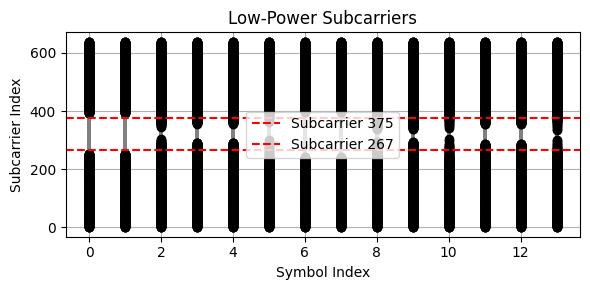

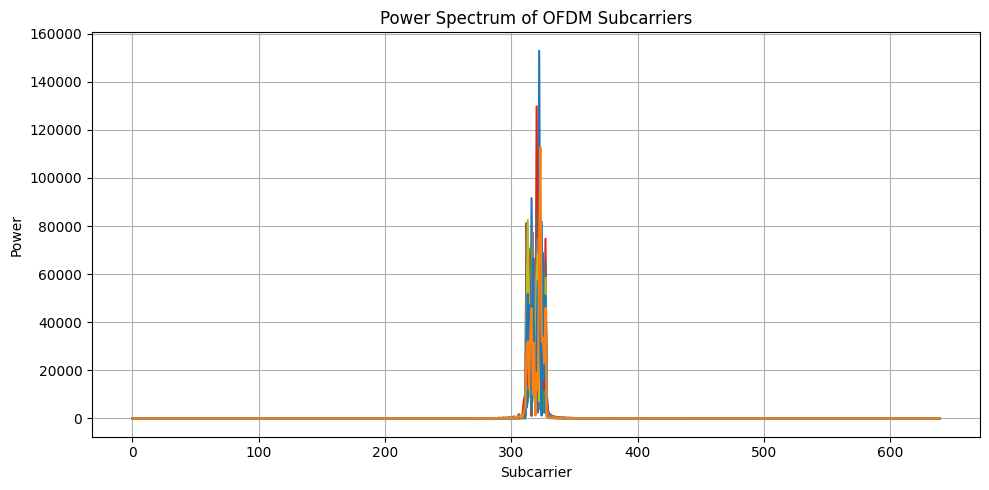

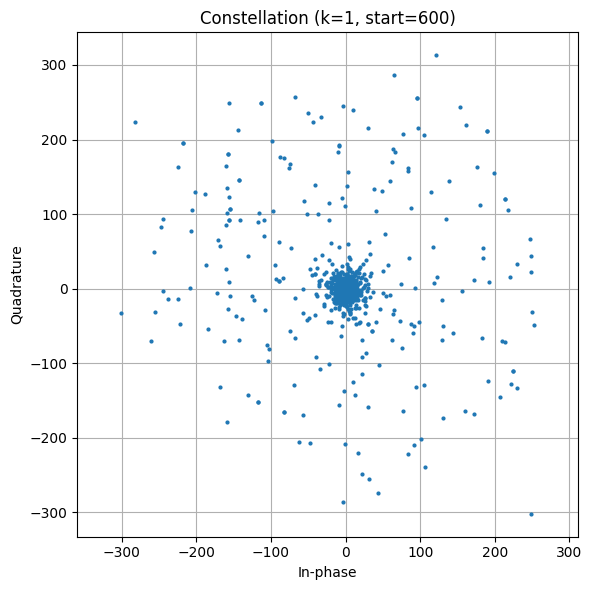

In [246]:
for k in [1]:
    Lcp = int(80 / k)
    Ld = int(640 / k)
    Ls = Lcp + Ld
    print(f"\nRunning with k={k}: Lcp={Lcp}, Ld={Ld}, Ls={Ls}")

    # Optional: downsample
    x_down = x_raw[::k]

    for indd in [start_index]:
        x = x_raw[indd:]
        N = len(x)
        num_symbols = 14
        total_length = num_symbols * Ls

        if total_length > N:
            print("Not enough data for full symbols")
            continue

        x_truncated = x[:total_length]
        x_symbols = x_truncated.reshape((Ls, num_symbols), order='F')
        x_no_cp = x_symbols[Lcp:, :]  # shape: (Ld, num_symbols)

        # FFT + fftshift
        X_symbols = np.fft.fftshift(np.fft.fft(x_no_cp, n=Ld, axis=0), axes=0)

        # Detect low-power subcarriers (|X|^2 < 20)
        magnitude_squared = np.abs(X_symbols)**2
        rows, cols = np.where(magnitude_squared < 20)

        # Stem plot of low-power subcarriers
        plt.figure(figsize=(6, 3))
        plt.stem(cols, rows, linefmt='gray', markerfmt='ko', basefmt=' ')
        plt.axhline(375, color='r', linestyle='--', label='Subcarrier 375')
        plt.axhline(267, color='r', linestyle='--', label='Subcarrier 267')
        plt.title('Low-Power Subcarriers')
        plt.xlabel('Symbol Index')
        plt.ylabel('Subcarrier Index')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Per-symbol power spectrum
        plt.figure(figsize=(10, 5))
        for l in range(2, 14):  # Python index 2 = MATLAB index 3
            plt.plot(range(Ld), magnitude_squared[:, l])
        plt.xlabel('Subcarrier')
        plt.ylabel('Power')
        plt.title('Power Spectrum of OFDM Subcarriers')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Flatten for constellation plot
        constellation_points = X_symbols.flatten()

        # Plot constellation
        plt.figure(figsize=(6, 6))
        plt.plot(np.real(constellation_points), np.imag(constellation_points), 'o', markersize=2)
        plt.title(f'Constellation (k={k}, start={indd})')
        plt.xlabel('In-phase')
        plt.ylabel('Quadrature')
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()